# DataBlock Walkthrough 

> Fill in a module description here

In [ ]:
#| default_exp DataBlockWalkthrough 

In [ ]:
#| hide
#| export
from nbdev.showdoc import *

# The `DataBock` API Introduction

The `DataBlock` API from fastai is a powerful library for building custom data processing pipelines. It's a core part of the fastai high level api workflow.

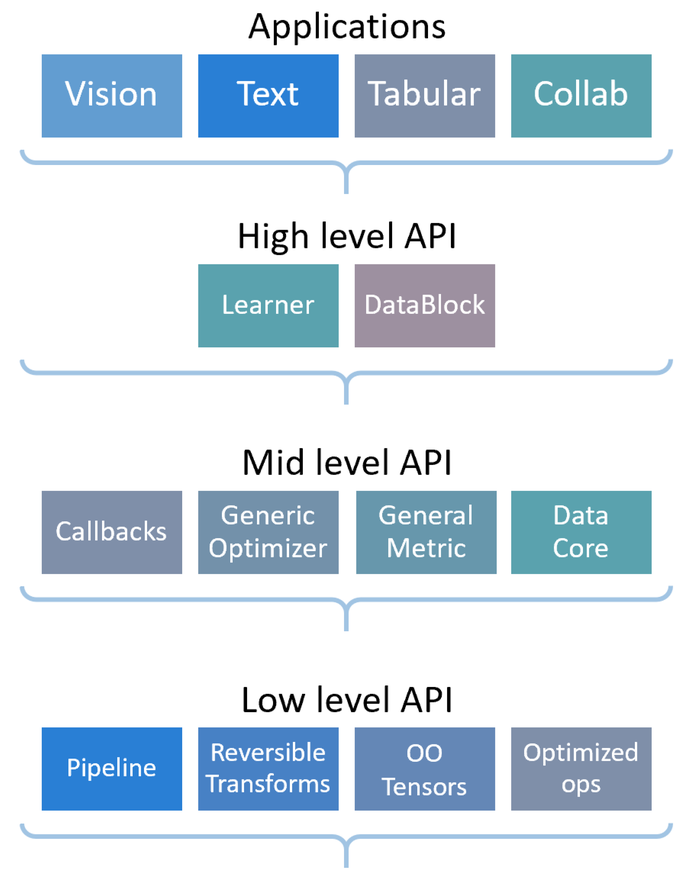


**Quick note on fastai's API Design**

Fastai's API design philosophy emphasizes simplicity and flexibility. This is an approach that I really appreciate. When I evaluate a new library, It's natural for me to build something simple to get a quick win, and iterativly build up to a more complex application. In my line of work, being able to scale down and prove out a concept is just as important as being able to scale up.

Key aspects of fastai's API design that I think are important are:

1) Sensible defaults: Many functions come with pre-configured settings that work well for common use cases. You'll see this in action with the `DataBlock` API. Having your ML framework choose sensible defaults based on a type system is something I really like.

3) Layered API: The library provides both high-level APIs for rapid development and low-level APIs for fine-grained control. This goes back to the idea of being able to prove a concept quickly without having to rewrite everything once you're ready to scale. Fastai is built on top of PyTorch, so the deeper you go into the library, the more you'll just be using PyTorch. Which is also great!

4) The library is very well documented, very hackable, and is easy to understand. This is a huge benefit for those of us that don't have a large team and need to really be able to rely on the library's documentation for more complex applications.

Great, now let's go DataBlock crazy!

Start by importing the modules we'll need for this walkthrough.

In [ ]:
#| export
from fastai.data.all import *
from fastai.vision.all import *

In [ ]:
# we are now going to download the pets dataset from URLs this returns a pathlib object
path = untar_data(URLs.PETS)
path

Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet')

If you're ever curious about what you are working with in fastai, assuming you're in a notebook, you can user the `??` command to get a quick overview of the object's source code. You can also use `show_doc` to get a detailed description of the object's API.

In [ ]:
# here is the `show_doc` for `untar_data`
show_doc(untar_data)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/data/external.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### untar_data

>      untar_data (url:str, archive:pathlib.Path=None, data:pathlib.Path=None,
>                  c_key:str='data', force_download:bool=False,
>                  base:str='~/.fastai')

*Download `url` using `FastDownload.get`*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| url | str |  | File to download |
| archive | Path | None | Optional override for `Config`'s `archive` key |
| data | Path | None | Optional override for `Config`'s `data` key |
| c_key | str | data | Key in `Config` where to extract file |
| force_download | bool | False | Setting to `True` will overwrite any existing copy of data |
| base | str | ~/.fastai | Directory containing config file and base of relative paths |
| **Returns** | **Path** |  | **Path to extracted file(s)** |

In [ ]:
# here is the source code for `URLs`
URLs??

Init signature: URLs()
Source:        
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    MDL = 'http://files.fast.ai/models/'
    GOOGLE = 'https://storage.googleapis.com/'
    S3  = 'https://s3.amazonaws.com/fast-ai-'
    URL = f'{S3}sample/'

    S3_IMAGE    = f'{S3}imageclas/'
    S3_IMAGELOC = f'{S3}imagelocal/'
    S3_AUDI     = f'{S3}audio/'
    S3_NLP      = f'{S3}nlp/'
    S3_COCO     = f'{S3}coco/'
    S3_MODEL    = f'{S3}modelzoo/'

    # main datasets
    ADULT_SAMPLE        = f'{URL}adult_sample.tgz'
    BIWI_SAMPLE         = f'{URL}biwi_sample.tgz'
    CIFAR               = f'{URL}cifar10.tgz'
    COCO_SAMPLE         = f'{S3_COCO}coco_sample.tgz'
    COCO_TINY           = f'{S3_COCO}coco_tiny.tgz'
    HUMAN_NUMBERS       = f'{URL}human_numbers.tgz'
    IMDB                = f'{S3_NLP}imdb.tgz'
    IMDB_SAMPLE         = f'{URL}imdb_sample.tgz'
    ML_SAMPLE           = f'{URL}movie_lens_sample.tgz'
    ML_100k             = 'ht

In [ ]:
# let's instantiate a `DataBlock` object
dblock = DataBlock()

In [ ]:
# by itself, a `DataBlock` is just a blueprint for how to assemple your data. For us to do 
# anything, useful with it we need to pass in a source and what we want the dblock to return.

# You get two options - A `Datasets` object or a `DataLoaders` object.

dsets = dblock.datasets(get_image_files(path/"images"))

In [ ]:
# We will see our file repeated twice, that is because by default,
# the `DataBlock` API assumes we have an input and a target and will wrape it in a tuple.
dsets.train[0]

(Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_152.jpg'),
 Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_152.jpg'))

If we look at the type...

In [ ]:
type(dsets)

fastai.data.core.Datasets

We just stamped out a `Datasets` object. Let's dive a little deeper into what we just created.

## Datasets

Datasets can be thought of as a object that returns a tuple from `items`, such as `(input, target)` and applies a `Pipeline` or `Transform` to each item in `items`. 

Someting important to note is that for each transform in `tfms`, it creates an element in the tuple. So that means if you have two transforms, you'll have a tuple of length 2, if you have three transforms, you'll have a tuple of length 3, and so on. Let's see an exmample.

In [ ]:
# items we are going to pass into `Datasets`
items = [1, 2, 3, 4]

# making a datasets object with no transforms will product a tuple of length 1
# basicially, just the item in items wrapped in a tuple 
# [1, 2, 3, 4] -> [(1, ), (2, ), (3, ), (4, )]

dsets = Datasets(items)
dsets

(#4) [(1,),(2,),(3,),(4,)]

In [ ]:
# Now let's see what happens when we add a list of transforms
# in this case, I'm giving the argument `tfms` a list of two identity functions
# we'll get back out a tuple of length 2 packing up our list into a list of tuples
# [1, 2, 3, 4] -> [(1, 1), (2, 2), (3, 3), (4, 4)]

dsets = Datasets(items, tfms=[lambda i: i, lambda i: i])
dsets

(#4) [(1, 1),(2, 2),(3, 3),(4, 4)]

In [ ]:
# Let's get more creative and create a dataset where our dependent variable is the item
# in items and our dependent variable is a the result of the function f(x) = x**2
# [1, 2, 3, 4] -> [(1, 1), (2, 4), (3, 9), (4, 16)]
dsets = Datasets(items, tfms=[lambda i: i, lambda i: i**2])
dsets

(#4) [(1, 1),(2, 4),(3, 9),(4, 16)]

In [ ]:
# or let's build a dataset where we output a tuple of length 3
dsets = Datasets(items, tfms=[lambda i: i, lambda i: i**2, lambda i: i**3])
dsets

(#4) [(1, 1, 1),(2, 4, 8),(3, 9, 27),(4, 16, 64)]

In [ ]:
# Let's get even more creative! Let's say I had a list of transforms for the dependent variable
# and a list of transforms for the independent variable. Can we do this? Yes we can!

dsets = Datasets(items, tfms=[[lambda i: i**2, lambda i: i+1], [lambda i: i**2, lambda i: i+2]])
dsets

(#4) [(2, 3),(5, 6),(10, 11),(17, 18)]

In [ ]:
# We can also use a `Pipeline` object to chain our transforms together.
pipe = Pipeline([lambda i: i**2, lambda i: i+1])

# now we have a pipeline that will take x and return x**2 + 1
test_eq(pipe(2), 5)
test_eq(pipe(3), 10)

In [ ]:
# We can use this pipeline to create a dataset.
dsets = Datasets(items, tfms=[pipe, pipe])
dsets
# We can also use a `Transform` object to transform our data.

(#4) [(2, 2),(5, 5),(10, 10),(17, 17)]

What if we want to split our data into a training and validation set?

This is where we can tell `Datasets` to split our data into a training and validation set. I personally like to use python's builtin `slice` function to do this. Slices in python are great, it's a flexible way for us to tell `Datasets` which indices we want to start and stop for both our training and validation set.

In [ ]:
import numpy as np

# Generate 1000 data points
data = np.array([np.random.randint(0, 10, dtype=int) for _ in range(1000)]).reshape(1, -1)[0]

# find the index of where we plan to split out data
split = int(len(data) * 0.8)

# pass in our data, our transforms, and our split in the form of a list of slices
dset = Datasets(data, 
                tfms=[lambda x: x**2, lambda x: x+1],
                splits=[slice(0, split), slice(split, len(data))]
                )
# Let's inspect our data now
print(dset.train[0])
print(dset.valid[0])
print(f" Lenght of train: {len(dset.train)}, Length of valid: {len(dset.valid)}")

(49, 8)
(64, 9)
 Lenght of train: 800, Length of valid: 200


This wraps up my digression into `Datasets`. Knowing how they work can help us understand what `DataBlock` is doing for you when you call `DataBlock.datasets`. Knowing what `Datasets` is expecting is important (atleast for me) when i'm in data munging madness and need to debug complex data pipelines. 

Let's get back to `DataBlock`.

In [ ]:
# Remember, `DataBlock` is just a blueprint on how to construct a `Datasets` or 
# `DataLoaders` object. We can give `DataBlock` more information on how to stamp out
# our data objects.

dblock = DataBlock(get_items = get_image_files)

# Now we can pass a source to our call to `datasets` and we can get the same result as before

dsets = dblock.datasets(path/"images")
dsets[0]

(Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'))

In [ ]:
# Now that we know more information about `Datasets`, we can make our `DataBlock` more useful
# our tuples (input, target) contain a repeating file path. Let's clean this up a little.

dsets = DataBlock(
    get_items = get_image_files,
    get_y = lambda x: x.name,
).datasets(path/"images")

# Now our tuple should be the result of (filepath, label)
dsets[0]

(Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 'Egyptian_Mau_167.jpg')

We see that our label is the label of the file. For this we passed in a function to `get_y`. In the case of what we are going to use as an end-to-end example of using a `DataBlock` to train a model, we will need to create a function that will assign a label depending on a class that will be in our vocab.

So, for our example, let's make a simple classification model, let's predict whether or not a given image is a dog.

For this, our label will just be "cat" or "dog".

In [ ]:
# our get y function
def get_y(x):
    return "cat" if x.name[0].isupper() else "dog"

dblock = DataBlock(
    get_items = get_image_files,
    get_y     = get_y,
)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/basset_hound_199.jpg'),
 'dog')

Nice. Now comes the interesting part of the `DataBlock` API and that is it's type system.

I can tell `DataBlock` what type of data I'm working with and it will give me a good amount of reasonable defaults, all the way down to the loss function I should use. This is really cool for me, going back to what I said earlier about "scaling down". Most of my work requires me to be fast, really fast. Having a solid foundation of what type of data I'm working with, then having fastai do a lot of the tedious work under the hood for me is something I find really cool.

Yes, sometimes I want to dig deep into a new loss function, or optimizer.....but most times, I just want something to work. Fastai is the best DSL i've come into use with.

Let's see what I'm talking about.

In [ ]:
# I know that I want to predicit a label (cat or dog) from an image.
# So, I can tell `DataBlock` more information about my data by specifying blocks
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # this is what is new!
    get_items = get_image_files,
    get_y = get_y,
)

# by specifying blocks, we are telling `DataBlock` that we are working with a tuple of 
# (image, category). If we now stamp out a `Datasets` object, you'll see extra magic happen.

dsets = dblock.datasets(path/"images")
dsets[0]

(PILImage mode=RGB size=183x275, TensorCategory(0))

In [ ]:
# Now let's apply transformations to resize our images to a consistent size
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=get_y,
    item_tfms=RandomResizedCrop(224, 224),
)

# Create datasets with the new DataBlock
ds = dblock.datasets(path/"images")
ds[0]

(PILImage mode=RGB size=183x275, TensorCategory(0))

That is interesting. Let's inspect the data further by opening and displaying the image and looking up our label in the vocab.

Label: cat


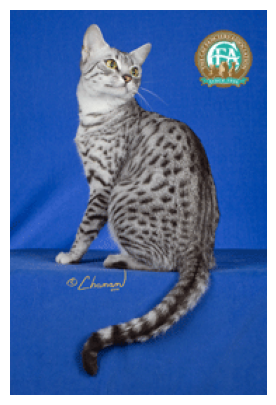

In [ ]:
# Let's open and display the image
img, label = dsets[0]
img.show()

# Print the label
print(f"Label: {dsets.vocab[label]}")

In [ ]:
# Let's now tell `DataBlock` how to split our data for training and validation.

dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = get_y,
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # split 20% of data to validation
)

# let's inspect our dblock with `summary`
dblock.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying get_y gives
      dog
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(1))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 375])
	Item at index 1 has shape: torch.Size([3, 333, 500])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size

Opps! We have an error. If we follow the trace that `summary` gives us, we can see that we are able to build up a single example of our data easily (which means we can bulid up a `Datasets` object). However, we break when we attempt to collate our data into batches. 

Why is that? Well, our `summary` tels us:

```
Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 500, 375])
	Item at index 1 has shape: torch.Size([3, 333, 500])
```

Our images are of different sizes! `DataBlock` gives us a method to change this. We can pass in a transform to `item_tfms` to apply a transform to our independent variables. This should fix the issue.

In [ ]:
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = get_y,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms = Resize(224), # resize each image to 224x224
)

dblock.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/giannicrivello/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying get_y gives
      dog
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(1))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


Awesome. Now we are ready to stamp out our `Dataloaders` object and train a model. But first, let's take a quick digresstion to talk about `Dataloaders`.

# Dataloaders

When training a model, you generally want to collate your data into batches and move it to a GPU (or some other accelerator). `DataLoaders` let's you do this.

`DataLoaders` is a wrapper around `DataLoader` that provides a few extra features. Let's first understand what a `DataLoader` is. A `DataLoader` can be pretty simple, you give it a `Dataset` and a `bs` (batch size) and it will return to you a generator of batches.

In [ ]:
# Create a datasets object using get_image_files
path = Path('/Users/giannicrivello/.fastai/data/oxford-iiit-pet')
files = get_image_files(path/'images')

# user what we learned before form `Datasets`, I can create a dataset by passing in 
# how I want my data to be transformed, in this case:
# PILImage.create | resize | ToTensor
dset = Datasets(files, 
                tfms=[
                    [PILImage.create, Resize(224), ToTensor], 
                    [lambda x: 0 if x.name[0].isupper() else 1]
                ])

# Create a dataloader object passing in our dataset and batch size
loader = DataLoader(dset, bs=32)

# let's get a batch of data
x, y = first(loader)
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Nice, now `DataLoaders` are just a wrapper around multiple `DataLoader`s.

Let's see this by taking our loader and passing it to a `DataLoaders` object.

In [ ]:
# Let's wrape our loaders in a `DataLoaders` object
dls = DataLoaders(loader, loader)

# Let's get a batch from our train and valid loaders
x_train, y_train = dls.train.one_batch()
x_valid, y_valid= dls.valid.one_batch()
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])


Generally, you can think of a `Datasets` object as a way to collect a tuple of independent and dependent variables from a datasource and apply transformations. A `DataLoader` object is a way for us to collate our data into batches, and move our data to a GPU.

Now we're ready to finally use our `DataBlock` to create a `DataLoaders` object that can be batched, moved to a GPU, and used for training a classification model.


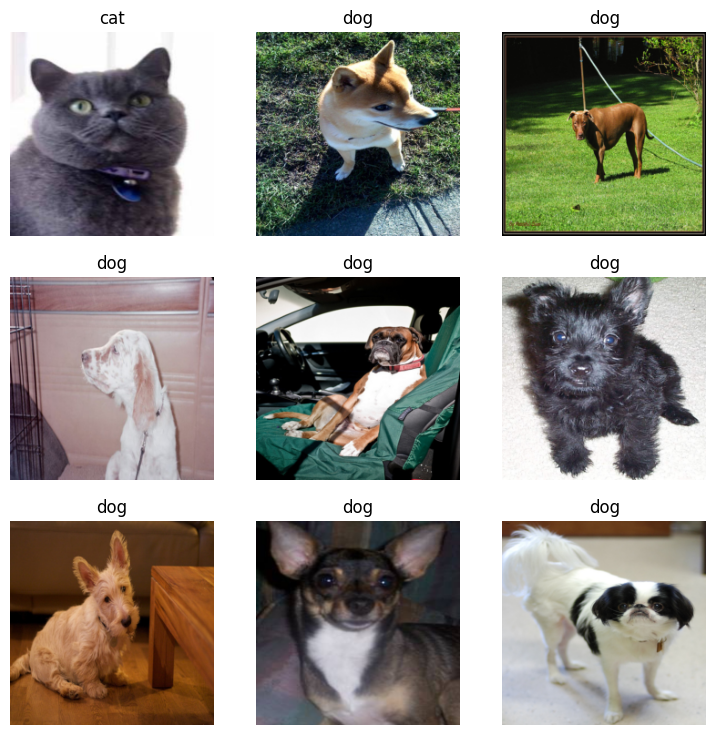

In [ ]:
# Once again, here is our `DataBlock` 
dblock = DataBlock(
    blocks    = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y     = get_y,
    splitter  = RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms = RandomResizedCrop(224, 224),
)

# Let's now stamp out a `DataLoaders` object
dls = dblock.dataloaders(path/"images")
dls.show_batch()

In [ ]:
# all looks good, let's just make sure we can grab a batch from our `DataLoaders` object
# and that everything is working as expected.

x, y = dls.train.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
# Let's now train a model and capture how long it takes
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 3.1 μs


epoch,train_loss,valid_loss,accuracy,time
0,0.966686,0.359588,0.851150,01:28


And there it is! We've just trained a model for one epoch on our data that reaches 85% accuracy. We did this by simply passing our `dls` into a `vision_learner`. I'm not going to got into depth on the details of the `vision_leaner`, I'll leave that for another post. That being said, our `DataBlock` does alot of the heavy lifting for us. Let's inspect a little...

In [ ]:
# Let's look at some of the defaults our `DataBlock` chose for us.

# One of the most important things our `DataBlock` did was choose a loss function for us.
print(f"Loss Function: {dls.loss_func}")

Loss Function: FlattenedLoss of CrossEntropyLoss()


But how did it know to choose cross entropy loss? Well, that's because we told our `DataBlock` that we were working with Image data and that our target was a category. We did this by passing in this line of code:

```
blocks = (ImageBlock, CategoryBlock)
```

Fastai's high level API is a nice paradigm to think about deep learning problems as defined by the *type* data we are working with as our independant variable and the *type* of target we are trying to predict.

I enjoy this approach because it allows a user to think about the problem more abstractly, without worrying aobut the specifics of the model.

For someone that just want to solve a problem, quick and dirty, this is a huge benefit.

Let's now rinse and repeat with different *types* of data.

# MNIST

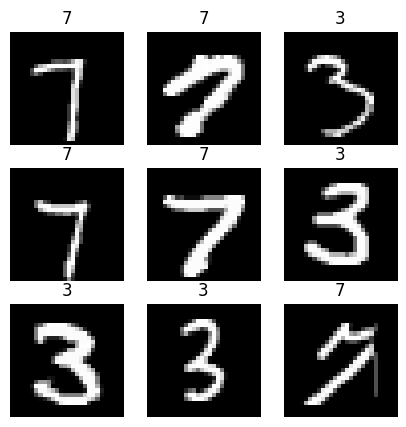

In [ ]:
mnist_dblock  = DataBlock(
    blocks    = (ImageBlock(cls=PILImage), CategoryBlock),
    get_items = get_image_files,
    get_y     = lambda x: x.parent.name, # the name of the class will be the parent directory
    splitter  = GrandparentSplitter(),   # We are going to use the grandparent splitter to split our data
)

dls = mnist_dblock.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(figsize=(5, 5))

Now let's train another model.

In [ ]:
mnist_learn = vision_learner(dls, resnet18, metrics=accuracy)
mnist_learn.fit_one_cycle(3, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.794717,5.435191,0.414878,00:01
1,0.755198,1.027816,0.882690,00:00
2,0.553269,0.779254,0.931330,00:01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


label: 7


<Axes: >

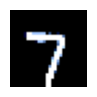

In [ ]:
# This time, let's use our trained model to predict on a data point
x, y = dls.valid.one_batch()
print(f"label: {dls.vocab[y[0]]}")
x[0].show()

In [ ]:
# let's see what our model predicts
decoded, _ , preds =  mnist_learn.predict(x[0].cpu())
print(f"Predictions: {preds}")
print(f"Label: {decoded}")


Predictions: tensor([0.0013, 0.9987])
Label: 7


In [ ]:
# Let's do another example of classification
pets_dblock    = DataBlock(
    blocks     = (ImageBlock, CategoryBlock),
    splitter   = RandomSplitter(valid_pct=0.2, seed=42),
    get_items  = get_image_files,
    get_y      = Pipeline([
                attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')
                ]),
    item_tfms  = Resize(128),
    batch_tfms = aug_transforms(size=128)
)

Just as a note, attrgetter is just a function that will get an attribute from a passed argument. Here is a quick example of what it does.

In [ ]:
from typing import NamedTuple

class MyObj(NamedTuple):
    a: str 

my_obj = MyObj("Get this attribute")
my_obj

MyObj(a='Get this attribute')

In [ ]:
# now, here is my attrgetter
attrgetter("a")(my_obj)

'Get this attribute'

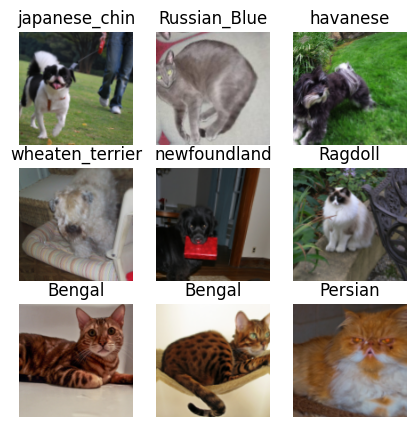

In [ ]:
# Now, once again, let's stamp out a `DataLoaders` object
pets_dls = pets_dblock.dataloaders(untar_data(URLs.PETS)/ "images").cpu()
pets_dls.show_batch(figsize=(5, 5))

In [ ]:
# let's look at the vocab
pets_dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [ ]:
# Let's now train a model
pets_learn = vision_learner(pets_dls.cpu(), resnet34, metrics=accuracy)
pets_learn.model.cpu()
pets_learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.461012,3.290012,0.106901,03:51


Let's now see something a little different. Let's now stamp our a `DataLoaders` object using a pandas DataFrame. To do this, we'll use the PASCAL dataset.

In [ ]:
pascal_source = untar_data(URLs.PASCAL_2007)
pascal_df = pd.read_csv(pascal_source/"train.csv")
pascal_df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


This will be a multi-label classification problem. There are a few things to note here.

1. The path to the image is given by the `fname` column
2. The lables are given by the `labels` column and there are more than one label sperated by a space
3. We can parse the `is_valid` column to get us our split between train and validation

/Users/giannicrivello/miniconda3/envs/dev/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


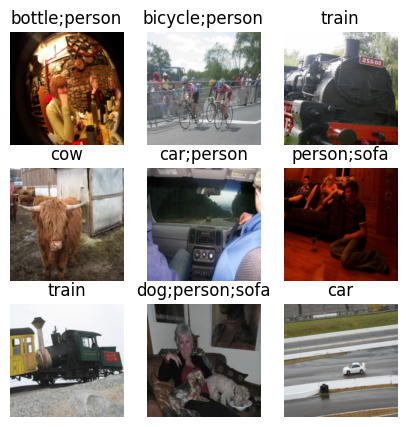

In [ ]:
pascal_dblock = DataBlock(
    blocks    = (ImageBlock, MultiCategoryBlock),
    get_x     = ColReader(0, pref=pascal_source/"train"),
    get_y     = ColReader(1, label_delim=" "),
    item_tfms = RandomResizedCrop(224, 224),
    splitter  = ColSplitter(2),
    batch_tfms = aug_transforms(size=224)
)

pascal_dls = pascal_dblock.dataloaders(pascal_df, device="cpu")
pascal_dls.show_batch(figsize=(5, 5))


`DataBlock` is flexible enough to work with different types of data sources. In this case, we are telling the `DataBlock` how to use a pandas DataFrame to create our `DataLoader`. Then we just stamp one out!


Now that we are using a `MultiCategoryBlock`, let's see the loss function our `DataBlock` chose for us.

In [ ]:
pascal_dls.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
# and let's train a model
pascal_learn = vision_learner(pascal_dls.cpu(), resnet34)
pascal_learn.model.cpu()
pascal_learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,time
0,0.459487,0.266029,05:15


Another really cool use case of the flexability of the `DataBlock` API is more complex vision data such as Image Localization.

# Segmentation


In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/Users/giannicrivello/.fastai/data/camvid_tiny/images'),Path('/Users/giannicrivello/.fastai/data/camvid_tiny/labels'),Path('/Users/giannicrivello/.fastai/data/camvid_tiny/codes.txt')]

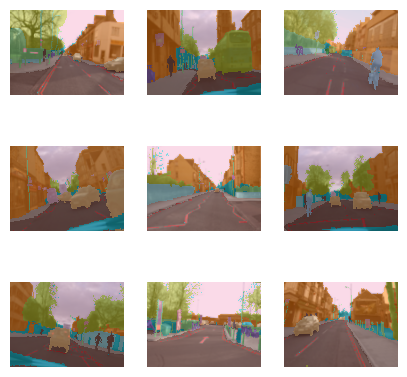

In [ ]:
camvid_dblock = DataBlock(
    blocks    = (ImageBlock, MaskBlock(codes = np.loadtxt(path/"codes.txt", dtype=str))),
    get_items = get_image_files,
    splitter  = RandomSplitter(),
    get_y     = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms = aug_transforms()
)

camvid_dls = camvid_dblock.dataloaders((path/'images'), bs=32, device="cpu")
camvid_dls.show_batch(figsize=(5, 5))

# Points

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)

fn2ctr = load_pickle(biwi_source/'centers.pkl')

/Users/giannicrivello/miniconda3/envs/dev/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

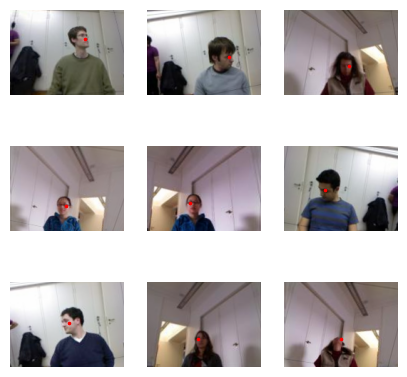

In [ ]:
dls = biwi.dataloaders(biwi_source, bs=32, device="cpu")
dls.show_batch(max_n=9, figsize=(5, 5))

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

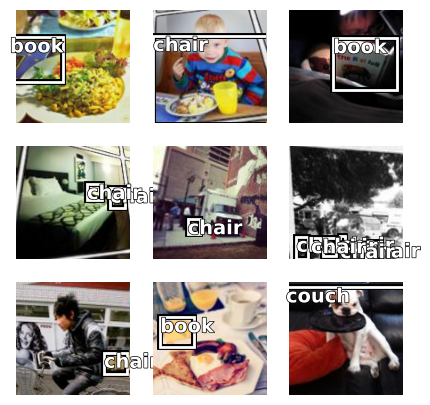

In [ ]:
dls = coco.dataloaders(coco_source, bs=32, device="cpu")
dls.show_batch(max_n=9, figsize=(5, 5))

This was all primarily vision tasks up to this point. Now let's flex the flexibility of the `DataBlock` API to create `DataLoaders` for language tasks.

In [ ]:
#| export
from fastai.text.all import *

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb_df = pd.read_csv(path/"texts.csv")
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
imdb_dblock = DataBlock(
    blocks = TextBlock.from_df("text", is_lm=True),
              get_x = ColReader(2),
              splitter = ColSplitter(),
)

In [ ]:
imdb_dls = imdb_dblock.dataloaders(imdb_df, bs=32, seq_len=72, device="cpu")
imdb_dls.show_batch(max_n=9, figsize=(5, 5))

/Users/giannicrivello/miniconda3/envs/dev/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


,text,text_
0,"xxbos i am glad to read so many negative comments about the xxmaj tritter plot . xxmaj everyone i talk to says the same thing . xxmaj they like xxmaj house 's gruff nature and his intelligence , but really dislike the vindictiveness of this xxunk plot . xxmaj it cuts into the real nature of the hospital story and makes everyone angry at police authority . xxmaj it needs to have","i am glad to read so many negative comments about the xxmaj tritter plot . xxmaj everyone i talk to says the same thing . xxmaj they like xxmaj house 's gruff nature and his intelligence , but really dislike the vindictiveness of this xxunk plot . xxmaj it cuts into the real nature of the hospital story and makes everyone angry at police authority . xxmaj it needs to have a"
1,"village xxunk her . \n\n▁ xxmaj yeah it does n't sound as a original as xxmaj nurse xxmaj xxunk , but that 's not the point . xxmaj it is really to bring to life an interesting idea of a world of two enemies : xxmaj fire & xxmaj ice . xxmaj and it succeeds . \n\n▁ xxmaj as for the action scenes : superb . xxmaj they are well handled ,","xxunk her . \n\n▁ xxmaj yeah it does n't sound as a original as xxmaj nurse xxmaj xxunk , but that 's not the point . xxmaj it is really to bring to life an interesting idea of a world of two enemies : xxmaj fire & xxmaj ice . xxmaj and it succeeds . \n\n▁ xxmaj as for the action scenes : superb . xxmaj they are well handled , have"
2,"killed instantly , but it would seem that they are in fact the lucky ones . xxmaj steve returns to xxmaj earth a constantly xxunk mass of xxunk pulp ; as he turns into a savage killer , melting every step of the way , he is xxunk by his friend , xxmaj dr . xxmaj xxunk xxmaj nelson ( burr debenning ) . \n\n xxmaj this is often so xxunk funny","instantly , but it would seem that they are in fact the lucky ones . xxmaj steve returns to xxmaj earth a constantly xxunk mass of xxunk pulp ; as he turns into a savage killer , melting every step of the way , he is xxunk by his friend , xxmaj dr . xxmaj xxunk xxmaj nelson ( burr debenning ) . \n\n xxmaj this is often so xxunk funny -"
3,"was more writing - better writing , much better writing - and less gratuitous sexual imagery we might have something to work with . \n\n xxmaj this movie should have been shot , made and xxunk a hardcore porn movie all along ; it would have made more money . xxmaj it practically is a hardcore porn film already , and it remains the only non - porn movie xxmaj i 've","more writing - better writing , much better writing - and less gratuitous sexual imagery we might have something to work with . \n\n xxmaj this movie should have been shot , made and xxunk a hardcore porn movie all along ; it would have made more money . xxmaj it practically is a hardcore porn film already , and it remains the only non - porn movie xxmaj i 've seen"
4,"xxmaj times "" . xxmaj they were exactly the same characters but with different xxunk xxmaj sam xxmaj foster was the xxmaj dad , his wife was xxmaj pearl xxmaj foster and the three children were xxmaj xxunk ( a young xxmaj xxunk xxmaj henry ) , xxmaj shirley and xxmaj benjamin . xxmaj pearl 's xxunk friend was xxmaj xxunk . ( to read about xxmaj the xxmaj fosters , i","times "" . xxmaj they were exactly the same characters but with different xxunk xxmaj sam xxmaj foster was the xxmaj dad , his wife was xxmaj pearl xxmaj foster and the three children were xxmaj xxunk ( a young xxmaj xxunk xxmaj henry ) , xxmaj shirley and xxmaj benjamin . xxmaj pearl 's xxunk friend was xxmaj xxunk . ( to read about xxmaj the xxmaj fosters , i have"
5,"so , though the movie says it is all about letting someone else , other than xxmaj allen , get the girl , she does n't get anyone . xxmaj jackman , the man she 's been making love to , is a man who murdered a prostitute . xxmaj nice , xxmaj woody . xxmaj nice way to xxunk your heroine for being beyond your grasp . \n\n xxmaj in a",", though the movie says it is all abo

# TODO, walk through the ULMFit approach to training a language model, building up the dataloaders with the DataBlock API.

# TODO, walk through the tabular data example

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()